# MRNet dataset

Using device: cuda
Checking directory: mrnetdata/train\0
Checking directory: mrnetdata/train\1
Total images loaded: 7267
Starting Fold 1/7
Epoch [1/20]
Train Loss: 0.4673, Train Accu: 75.40% Train Loss: 0.4053, Train Accu: 78.00% val Loss: 0.4754, val Accu: 73.16% Prec: 0.7568, Recall: 0.7316, F1: 0.7342
Epoch [2/20]
Train Loss: 0.4345, Train Accu: 82.64% Train Loss: 0.3834, Train Accu: 83.50% val Loss: 0.4355, val Accu: 83.47% Prec: 0.8338, Recall: 0.8347, F1: 0.8334
Epoch [3/20]
Train Loss: 0.3753, Train Accu: 86.66% Train Loss: 0.3327, Train Accu: 87.99% val Loss: 0.3796, val Accu: 85.73% Prec: 0.8847, Recall: 0.8573, F1: 0.8494
Epoch [4/20]
Train Loss: 0.3473, Train Accu: 86.68% Train Loss: 0.3138, Train Accu: 87.99% val Loss: 0.3528, val Accu: 85.73% Prec: 0.8847, Recall: 0.8573, F1: 0.8494
Epoch [5/20]
Train Loss: 0.3776, Train Accu: 86.66% Train Loss: 0.3352, Train Accu: 87.99% val Loss: 0.3823, val Accu: 85.73% Prec: 0.8847, Recall: 0.8573, F1: 0.8494
Epoch [6/20]
Train Loss: 0

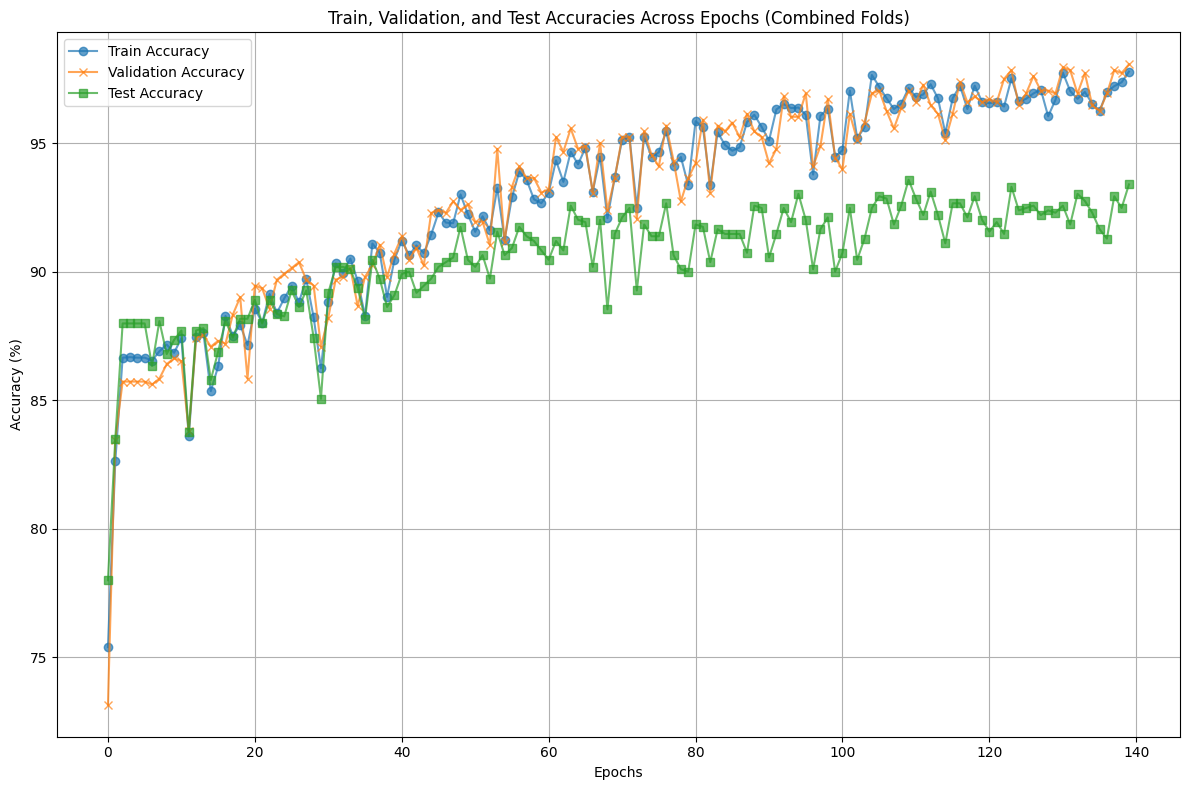

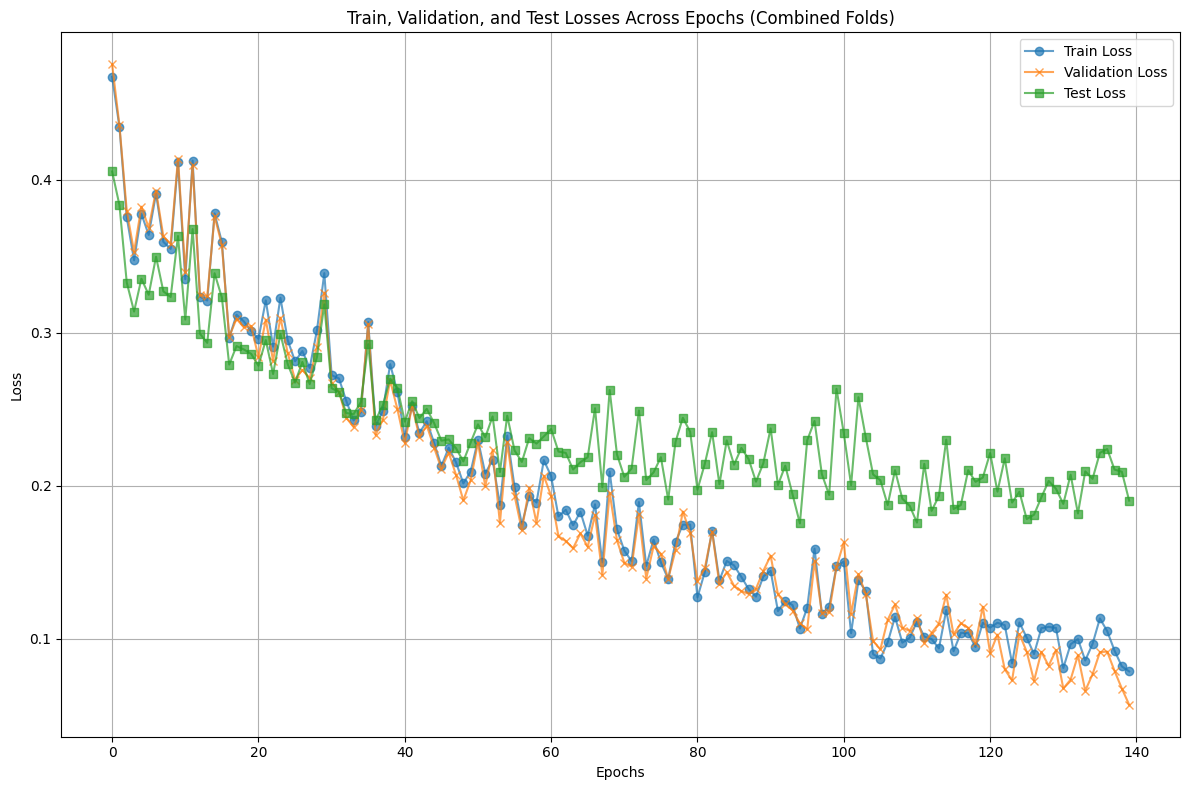

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset , random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import label_binarize

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            print(f"Checking directory: {label_dir}")
            if os.path.isdir(label_dir):
                sagittal_dir = os.path.join(label_dir, 'sagittal')
                axial_dir = os.path.join(label_dir, 'axial')
                coronal_dir = os.path.join(label_dir, 'coronal')

                # Ensure that all three planes have the same number of images
                sagittal_images = sorted([os.path.join(sagittal_dir, f) for f in os.listdir(sagittal_dir) if f.endswith('.jpg') or f.endswith('.png')])
                axial_images = sorted([os.path.join(axial_dir, f) for f in os.listdir(axial_dir) if f.endswith('.jpg') or f.endswith('.png')])
                coronal_images = sorted([os.path.join(coronal_dir, f) for f in os.listdir(coronal_dir) if f.endswith('.jpg') or f.endswith('.png')])

                # Ensure all planes have the same number of images
                assert len(sagittal_images) == len(axial_images) == len(coronal_images), "Mismatch in number of images per plane"

                # Append paths and labels for each image in all planes
                for sagittal, axial, coronal in zip(sagittal_images, axial_images, coronal_images):
                    self.image_paths.append((sagittal, axial, coronal))
                    self.labels.append(int(label))
                                
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        sagittal_path, axial_path, coronal_path = self.image_paths[idx]
        
        # Load images for each plane
        sagittal_image = Image.open(sagittal_path).convert('L')
        axial_image = Image.open(axial_path).convert('L')
        coronal_image = Image.open(coronal_path).convert('L')
        label = self.labels[idx]

        # Apply transformations (if any)
        if self.transform:
            sagittal_image = self.transform(sagittal_image)
            axial_image = self.transform(axial_image)
            coronal_image = self.transform(coronal_image)

        return sagittal_image, axial_image, coronal_image, label

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Load dataset
data_dir = 'mrnetdata/train'
full_dataset = CustomDataset(root_dir=data_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# ELNet Implementation
class MultiSliceNorm(nn.Module):
    def __init__(self, num_channels):
        super(MultiSliceNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_channels))
        self.beta = nn.Parameter(torch.zeros(num_channels))
        self.eps = 1e-8

    def forward(self, x):
        mean = x.mean(dim=(2, 3), keepdim=True)
        var = x.var(dim=(2, 3), keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)

class BlurPool(nn.Module):
    def __init__(self, channels, stride=2, kernel_size=3):
        super(BlurPool, self).__init__()
        self.stride = stride
        self.padding = (kernel_size - 1) // 2
        filter = torch.tensor([1, 2, 1], dtype=torch.float32)
        filter = filter[:, None] * filter[None, :]
        filter /= filter.sum()
        self.register_buffer('filter', filter[None, None].repeat(channels, 1, 1, 1))

    def forward(self, x):
        return F.conv2d(x, self.filter, stride=self.stride, padding=self.padding, groups=x.shape[1])

class ELNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ELNetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.norm = MultiSliceNorm(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

class ELNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ELNet, self).__init__()
        # Initial layer
        self.layer1 = nn.Conv2d(1, 4, kernel_size=7, stride=2, padding=3)  # Outputs 4 channels
        self.norm1 = MultiSliceNorm(4)
        self.relu1 = nn.ReLU()
        self.blurpool1 = BlurPool(4)

        # Subsequent blocks
        self.block1 = self._make_block(4, 8, kernel_size=5, num_repeats=2)  # 4 -> 8 channels
        self.block2 = self._make_block(8, 16, kernel_size=3, num_repeats=2)  # 8 -> 16 channels

        # Classification head
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16 * 3, 512),  # Combine features from three planes (16 channels each)
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Final classification
        )

    def _make_block(self, in_channels, out_channels, kernel_size, num_repeats):
        layers = []
        for _ in range(num_repeats):
            layers.append(ELNetBlock(in_channels, out_channels, kernel_size))
            in_channels = out_channels  # Update in_channels for subsequent layers
        layers.append(BlurPool(out_channels))  # Downsample after each block
        return nn.Sequential(*layers)

    def forward(self, sagittal, axial, coronal):
        # Process a single modality through the network
        def process_single_plane(x):
            x = self.blurpool1(self.relu1(self.norm1(self.layer1(x))))
            x = self.block1(x)
            x = self.block2(x)
            x = F.adaptive_max_pool2d(x, 1).view(x.size(0), -1)  # Global max pooling
            return x

        sagittal = process_single_plane(sagittal)
        axial = process_single_plane(axial)
        coronal = process_single_plane(coronal)

        # Combine features from all three planes
        combined = torch.cat([sagittal, axial, coronal], dim=1)
        return self.fc(combined)

# Instantiate the model
model = ELNet(num_classes=2).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

def evaluate_metrics(loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for sagittal, axial, coronal, labels in loader:
            sagittal, axial, coronal, labels = sagittal.to(device), axial.to(device), coronal.to(device), labels.to(device)

            outputs = model(sagittal, axial, coronal)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for AUC
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Predicted classes
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # One-hot encode the labels
    num_classes = all_probs.shape[1]
    one_hot_labels = label_binarize(all_labels, classes=np.arange(num_classes))

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    metrics = {
        'Loss': val_loss / len(loader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        
    }

    return metrics

last_epoch_train_losses = []
last_epoch_train_accuracies = []
last_epoch_val_metrics = {
    'Loss': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# K-Fold Cross-Validation
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")
    
    # Subset datasets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    trainsub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    num_epochs = 20
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for sagittal, axial, coronal, labels in train_loader:
            sagittal, axial, coronal, labels = sagittal.to(device), axial.to(device), coronal.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sagittal, axial, coronal)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        
        train_metrics = evaluate_metrics(trainsub_loader, model, criterion, device)
        val_metrics = evaluate_metrics(val_loader, model, criterion, device)
        test_metrics = evaluate_metrics(test_loader, model, criterion, device)

        train_losses.append(train_metrics['Loss'])
        train_accuracies.append(train_metrics['Accuracy'])
        val_losses.append(val_metrics['Loss'])
        val_accuracies.append(val_metrics['Accuracy'])
        test_losses.append(test_metrics['Loss'])
        test_accuracies.append(test_metrics['Accuracy'])

        if epoch == num_epochs - 1:
            last_epoch_train_losses.append(running_loss / len(train_loader))
            last_epoch_train_accuracies.append(train_metrics['Accuracy'])
            for key in last_epoch_val_metrics:
                last_epoch_val_metrics[key].append(val_metrics[key])

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_metrics['Loss']:.4f}, Train Accu: {train_metrics['Accuracy']:.2f}%",
            f"Train Loss: {test_metrics['Loss']:.4f}, Train Accu: {test_metrics['Accuracy']:.2f}%",
            f"val Loss: {val_metrics['Loss']:.4f}, val Accu: {val_metrics['Accuracy']:.2f}%",
            f"Prec: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}, "
            f"F1: {val_metrics['F1 Score']:.4f}")
        
avg_train_loss = np.mean(last_epoch_train_losses)
avg_train_accuracy = np.mean(last_epoch_train_accuracies)
avg_val_metrics = {key: np.mean(values) for key, values in last_epoch_val_metrics.items()}

# Print average metrics
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print("Average Validation Metrics:")
for key, value in avg_val_metrics.items():
    print(f"{key}: {value:.4f}")

import matplotlib.pyplot as plt

# After your training loop and evaluation, you can plot all metrics

# Plot Train, Validation, and Test Accuracy
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='Train Accuracy', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='Validation Accuracy', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_accuracies)), test_accuracies, label='Test Accuracy', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Accuracies Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train, Validation, and Test Losses
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Losses Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# KneeMRI Dataset

Using device: cuda
Starting Fold 1/7
Epoch [1/20]
Train Loss: 1.0313, Train Accu: 49.73% Test Loss: 1.1264, Test Accu: 42.08% val Loss: 1.0261, val Accu: 53.36% Prec: 0.4433, Recall: 0.5336, F1: 0.4538 AUC: 0.7067, Kappa: 0.1898 Sens: 0.0000, Spec: 1.0000 Dice Coeff: 0.0000 RMSE: 0.9428, MAE: 0.6072, MSE: 0.8889 PPV: 0.0000
Epoch [2/20]
Train Loss: 1.0822, Train Accu: 48.45% Test Loss: 1.0610, Test Accu: 47.28% val Loss: 1.1250, val Accu: 48.67% Prec: 0.7322, Recall: 0.4867, F1: 0.4134 AUC: 0.7880, Kappa: 0.2089 Sens: 0.3790, Spec: 0.9612 Dice Coeff: 0.4921 RMSE: 0.7609, MAE: 0.5352, MSE: 0.5790 PPV: 0.7015
Epoch [3/20]
Train Loss: 0.5565, Train Accu: 79.08% Test Loss: 0.5580, Test Accu: 78.33% val Loss: 0.5415, val Accu: 77.93% Prec: 0.7811, Recall: 0.7793, F1: 0.7702 AUC: 0.9139, Kappa: 0.6459 Sens: 0.6532, Spec: 0.9398 Dice Coeff: 0.6864 RMSE: 0.5524, MAE: 0.2488, MSE: 0.3052 PPV: 0.7232
Epoch [4/20]
Train Loss: 0.5542, Train Accu: 77.38% Test Loss: 0.6143, Test Accu: 72.75% val Los

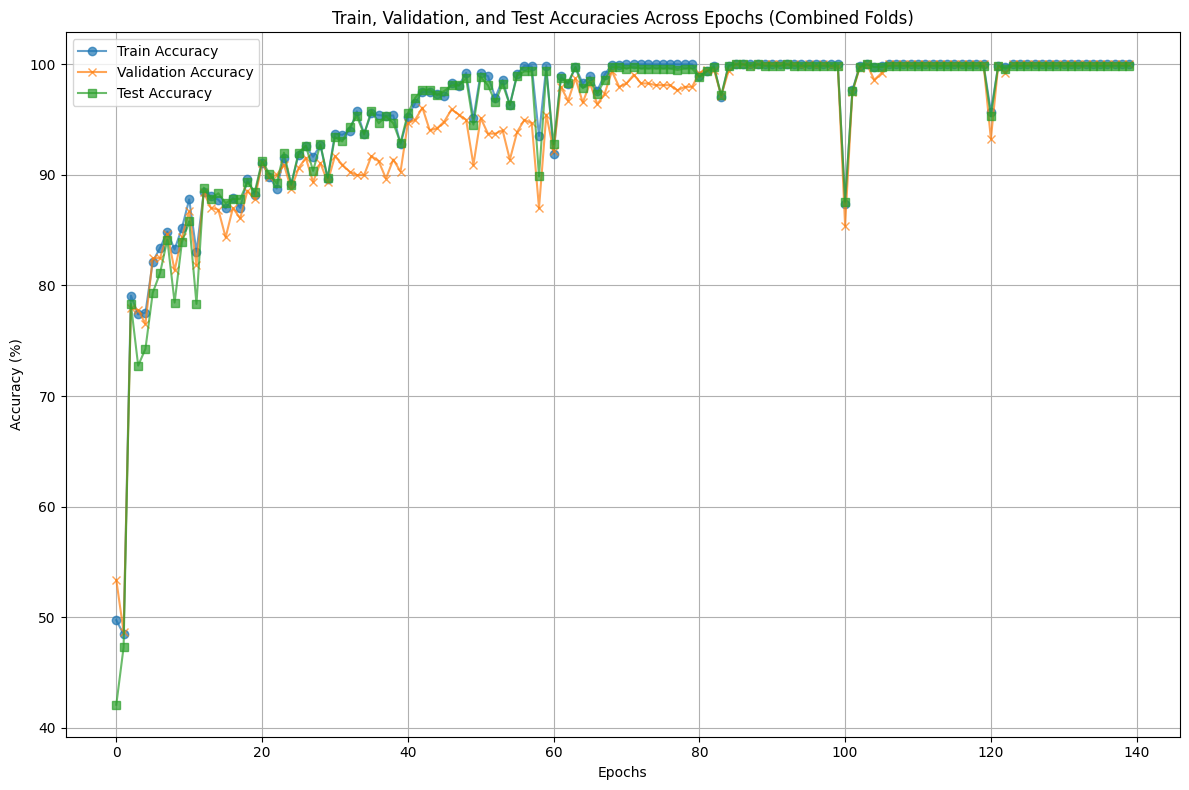

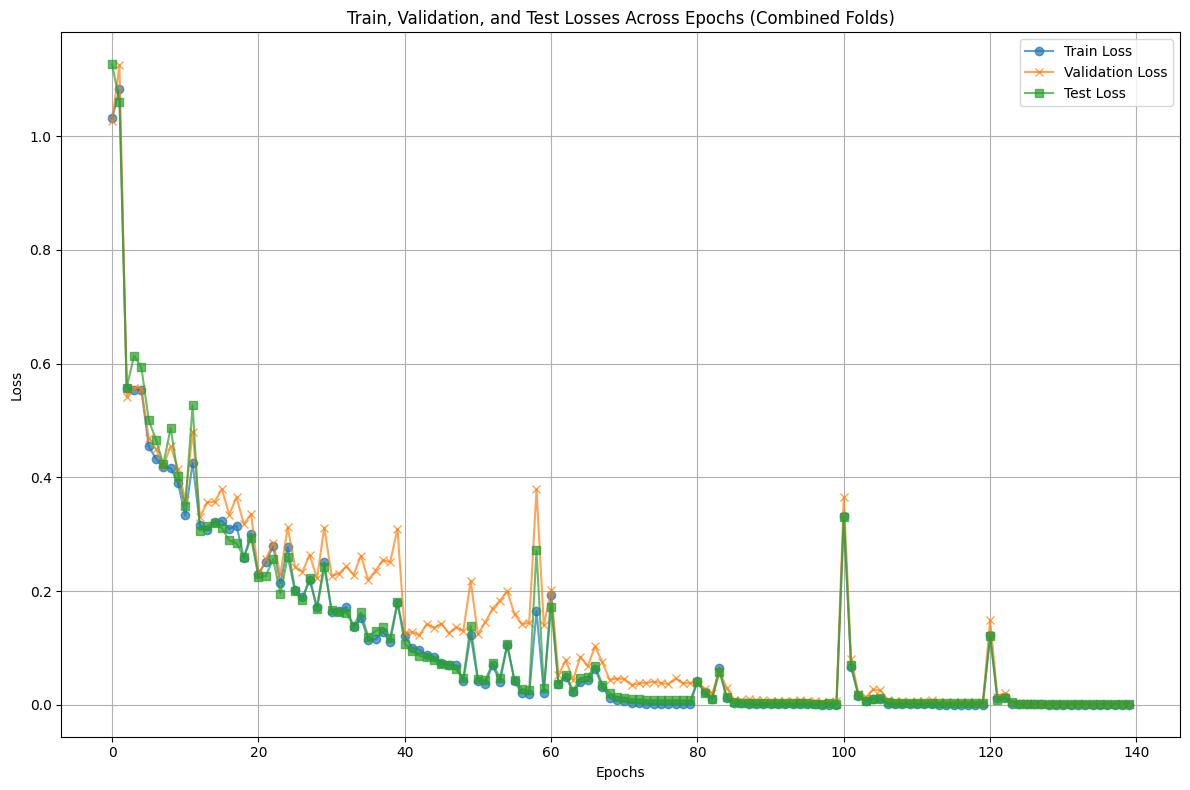

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset , random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import numpy as np

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure grayscale image loading
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Load dataset
data_dir = 'new dataf'
full_dataset = CustomDataset(root_dir=data_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
# Define the CNN model (already provided)
class BlurPool(nn.Module):
    def __init__(self, channels, stride=2):
        super(BlurPool, self).__init__()
        kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
        kernel /= kernel.sum()
        kernel = kernel.expand(channels, 1, 3, 3)
        self.register_buffer('kernel', kernel)
        self.stride = stride
        self.padding = 1

    def forward(self, x):
        return F.conv2d(x, self.kernel, stride=self.stride, padding=self.padding, groups=x.shape[1])

class MultiSliceNorm(nn.Module):
    def __init__(self, num_channels, norm_type='layer'):
        super(MultiSliceNorm, self).__init__()
        self.norm_type = norm_type
        self.num_channels = num_channels

    def forward(self, x):
        if self.norm_type == 'layer':
            # Dynamically infer the shape
            norm = nn.LayerNorm(x.size()[1:], elementwise_affine=False).to(x.device)
        elif self.norm_type == 'contrast':
            norm = nn.GroupNorm(1, self.num_channels).to(x.device)
        return norm(x)


class ELNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, norm_type='layer'):
        super(ELNetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.norm = MultiSliceNorm(out_channels, norm_type=norm_type)
        self.relu = nn.ReLU(inplace=True)
        self.blurpool = BlurPool(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.blurpool(x)
        return x

class ELNet(nn.Module):
    def __init__(self, num_classes=3, norm_type='layer'):
        super(ELNet, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.initial_pool = BlurPool(64)

        self.blocks = nn.Sequential(
            ELNetBlock(64, 128, kernel_size=5, norm_type=norm_type),
            ELNetBlock(128, 256, kernel_size=5, norm_type=norm_type),
            ELNetBlock(256, 512, kernel_size=3, norm_type=norm_type),
            ELNetBlock(512, 512, kernel_size=3, norm_type=norm_type)
        )

        self.global_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_pool(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example instantiation
model = ELNet(num_classes=3, norm_type='layer').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

def evaluate_metrics(loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for AUC
            preds = torch.argmax(outputs, dim=1).cpu().numpy()    # Predicted classes
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
     # Calculate metrics
    binary_labels = (all_labels == 2).astype(int)
    binary_preds = (all_preds == 2).astype(int)
    cm = confusion_matrix(binary_labels, binary_preds)
    
    
    # Handle multi-class confusion matrix 
    accuracy = accuracy_score(all_labels, all_preds)*100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # If binary classification calculate below metrics or use suitable multi-class metrics
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use the probabilities for the positive class
    kappa = cohen_kappa_score(all_labels, all_preds)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)

    metrics = {
        'Loss': val_loss / len(loader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Dice Coefficient': dice,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'PPV': ppv
    }

    return metrics

last_epoch_train_losses = []
last_epoch_train_accuracies = []
last_epoch_val_metrics = {
    'Loss': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [],
    'Kappa': [],
    'Sensitivity': [],
    'Specificity': [],
    'Dice Coefficient': [],
    'RMSE': [],
    'MAE': [],
    'MSE': [],
    'PPV': []
}

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# K-Fold Cross-Validation
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")
    
    # Subset datasets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    trainsub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    num_epochs = 20
    
    for epoch in range(20):  # Use smaller epochs for debugging; increase for full training
        model.train()
        running_loss = 0.0
        for images, labels in trainsub_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        
        train_metrics = evaluate_metrics(trainsub_loader, model, criterion, device)
        val_metrics = evaluate_metrics(val_loader, model, criterion, device)
        test_metrics = evaluate_metrics(test_loader, model, criterion, device)

        train_losses.append(train_metrics['Loss'])
        train_accuracies.append(train_metrics['Accuracy'])
        val_losses.append(val_metrics['Loss'])
        val_accuracies.append(val_metrics['Accuracy'])
        test_losses.append(test_metrics['Loss'])
        test_accuracies.append(test_metrics['Accuracy'])

        if epoch == num_epochs - 1:
            last_epoch_train_losses.append(running_loss / len(train_loader))
            last_epoch_train_accuracies.append(train_metrics['Accuracy'])
            for key in last_epoch_val_metrics:
                last_epoch_val_metrics[key].append(val_metrics[key])

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_metrics['Loss']:.4f}, Train Accu: {train_metrics['Accuracy']:.2f}%",
            f"Test Loss: {test_metrics['Loss']:.4f}, Test Accu: {test_metrics['Accuracy']:.2f}%",
            f"val Loss: {val_metrics['Loss']:.4f}, val Accu: {val_metrics['Accuracy']:.2f}%",
            f"Prec: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}, "
            f"F1: {val_metrics['F1 Score']:.4f}",
            f"AUC: {val_metrics['AUC']:.4f}, Kappa: {val_metrics['Kappa']:.4f}",
            f"Sens: {val_metrics['Sensitivity']:.4f}, Spec: {val_metrics['Specificity']:.4f}",
            f"Dice Coeff: {val_metrics['Dice Coefficient']:.4f}",
            f"RMSE: {val_metrics['RMSE']:.4f}, MAE: {val_metrics['MAE']:.4f}, MSE: {val_metrics['MSE']:.4f}",
            f"PPV: {val_metrics['PPV']:.4f}")

avg_train_loss = np.mean(last_epoch_train_losses)
avg_train_accuracy = np.mean(last_epoch_train_accuracies)
avg_val_metrics = {key: np.mean(values) for key, values in last_epoch_val_metrics.items()}

# Print average metrics
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print("Average Validation Metrics:")
for key, value in avg_val_metrics.items():
    print(f"{key}: {value:.4f}")

import matplotlib.pyplot as plt

# After your training loop and evaluation, you can plot all metrics

# Plot Train, Validation, and Test Accuracy
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='Train Accuracy', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='Validation Accuracy', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_accuracies)), test_accuracies, label='Test Accuracy', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Accuracies Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train, Validation, and Test Losses
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Losses Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()